Import libraries 

In [60]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

import warnings

warnings.filterwarnings('ignore')

Dataset Loading and Datetime Conversion

In [61]:
# Dataset loading
df_vanc = pd.read_csv("crime.csv")
#df_vanc['Reported Date'] = pd.to_datetime(df_vanc['Reported Date'], errors='coerce')
#df_vanc = df_vanc.dropna(subset=['Reported Date'])  # geçersiz tarihleri çıkar
#df_vanc = df_vanc.sort_values('Reported Date')

df_vanc.head()


,TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y,Latitude,Longitude
0,Other Theft,2003,5,12,16.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
1,Other Theft,2003,5,7,15.0,20.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
2,Other Theft,2003,4,23,16.0,40.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
3,Other Theft,2003,4,20,11.0,15.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763
4,Other Theft,2003,4,12,17.0,45.0,9XX TERMINAL AVE,Strathcona,493906.5,5457452.47,49.269802,-123.083763


Daily Summary and Applying it

In [62]:
def build_daily_summary_vancouver(df):
    # Yeni DATE sütunu oluştur (datetime biçiminde)
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
    df['DAY'] = df['DATE'].dt.date  # Sadece gün olarak tut

    grouped = df.groupby(['NEIGHBOURHOOD', 'DAY'])

    daily_features = []

    for (area, day), group in grouped:
        summary = {
            'NEIGHBOURHOOD': area,
            'DAY': day,
            'Crime_Count': len(group),
            'Crime_Mode': group['TYPE'].mode()[0] if not group['TYPE'].mode().empty else None
        }

        # Örnek histogram özellikleri (örnek kolonlara göre)
        for col in ['HOUR', 'MINUTE']:  
            summary[f"{col}_mean"] = group[col].mean()
            summary[f"{col}_max"] = group[col].max()

        daily_features.append(summary)

    return pd.DataFrame(daily_features)


daily_df = build_daily_summary_vancouver(df_vanc)
daily_df = daily_df.dropna(subset=['Crime_Mode']) # If there're NaN labels, then drop them

 

Rare Filtering

In [63]:
# build_daily_summary_rnn(daily_df) sonrası
value_counts = daily_df['Crime_Mode'].value_counts()


valid_crime_classes = value_counts[value_counts >= 500].index

# Sadece bu sınıfları içeren kayıtları tut
daily_df = daily_df[daily_df['Crime_Mode'].isin(valid_crime_classes)].reset_index(drop=True)

Sequences

In [64]:
def create_sequences_rnn(daily_df, window_size=5, feature_cols=None):
    data = []
    labels = []

    if feature_cols is None:
        exclude = ['NEIGHBOURHOOD', 'DAY', 'Crime_Mode']
        feature_cols = [col for col in daily_df.columns if col not in exclude]

    grouped = daily_df.groupby('NEIGHBOURHOOD')

    for neigh, group in grouped:
        group = group.sort_values(by='DAY').reset_index(drop=True)
        for i in range(len(group) - window_size):
            window = group.iloc[i:i+window_size]
            target_day = group.iloc[i+window_size]

            if pd.isnull(target_day['Crime_Mode']):
                continue

            x_seq = window[feature_cols].values.astype(np.float32)
            y_label = target_day['Crime_Mode']
            data.append(x_seq)
            labels.append(y_label)

    return np.array(data), np.array(labels), feature_cols


X, y, feature_cols = create_sequences_rnn(daily_df, window_size=5)
print("X shape:", X.shape)  # (n, t, f)
print("y shape:", y.shape)

X shape: (100990, 5, 5)
y shape: (100990,)


Sequence Preprocessing

In [65]:
def preprocess_sequences_rnn(X, y):
    n, t, f = X.shape
    X_reshaped = X.reshape(-1, f)

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X_reshaped).reshape(n, t, f)

    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    return X_scaled, y_encoded, scaler, le

X_scaled, y_encoded, scaler, le = preprocess_sequences_rnn(X, y)

In [66]:
class CrimeDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Dataset objeleri
train_dataset = CrimeDataset(X_train, y_train)
test_dataset = CrimeDataset(X_test, y_test)

# DataLoader objeleri
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Model

In [67]:
import torch.nn as nn

class LSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=1, dropout=0.3):
        super(LSTMClassifier, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (h_n, _) = self.lstm(x)
        out = self.fc(h_n[-1])  # h_n: (num_layers, batch, hidden_dim)
        return out

In [68]:
import torch.optim as optim

def train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)

        # Basit doğruluk çıktısı (her epoch)
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == y_batch).sum().item()
                total += y_batch.size(0)

        accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f} - Test Accuracy: {accuracy:.4f}")

    return model

input_dim = X_scaled.shape[2]
output_dim = len(np.unique(y_encoded))

model = LSTMClassifier(input_dim=input_dim, hidden_dim=128, output_dim=output_dim, num_layers=1, dropout=0.3)
trained_model = train_model(model, train_loader, test_loader, num_epochs=30, learning_rate=0.001)

Epoch 1/30 - Loss: 1.6954 - Test Accuracy: 0.3640
Epoch 2/30 - Loss: 1.6780 - Test Accuracy: 0.3640
Epoch 3/30 - Loss: 1.6745 - Test Accuracy: 0.3643
Epoch 4/30 - Loss: 1.6723 - Test Accuracy: 0.3640
Epoch 5/30 - Loss: 1.6710 - Test Accuracy: 0.3644
Epoch 6/30 - Loss: 1.6704 - Test Accuracy: 0.3650
Epoch 7/30 - Loss: 1.6695 - Test Accuracy: 0.3640
Epoch 8/30 - Loss: 1.6684 - Test Accuracy: 0.3648
Epoch 9/30 - Loss: 1.6686 - Test Accuracy: 0.3643
Epoch 10/30 - Loss: 1.6678 - Test Accuracy: 0.3645
Epoch 11/30 - Loss: 1.6675 - Test Accuracy: 0.3647
Epoch 12/30 - Loss: 1.6665 - Test Accuracy: 0.3649
Epoch 13/30 - Loss: 1.6661 - Test Accuracy: 0.3653
Epoch 14/30 - Loss: 1.6660 - Test Accuracy: 0.3648
Epoch 15/30 - Loss: 1.6653 - Test Accuracy: 0.3645
Epoch 16/30 - Loss: 1.6649 - Test Accuracy: 0.3653
Epoch 17/30 - Loss: 1.6644 - Test Accuracy: 0.3661
Epoch 18/30 - Loss: 1.6636 - Test Accuracy: 0.3664
Epoch 19/30 - Loss: 1.6632 - Test Accuracy: 0.3650
Epoch 20/30 - Loss: 1.6629 - Test Accura

Evaluation

Accuracy:  0.3713
F1-Score:  0.2693
Recall:    0.3713
Precision: 0.2365


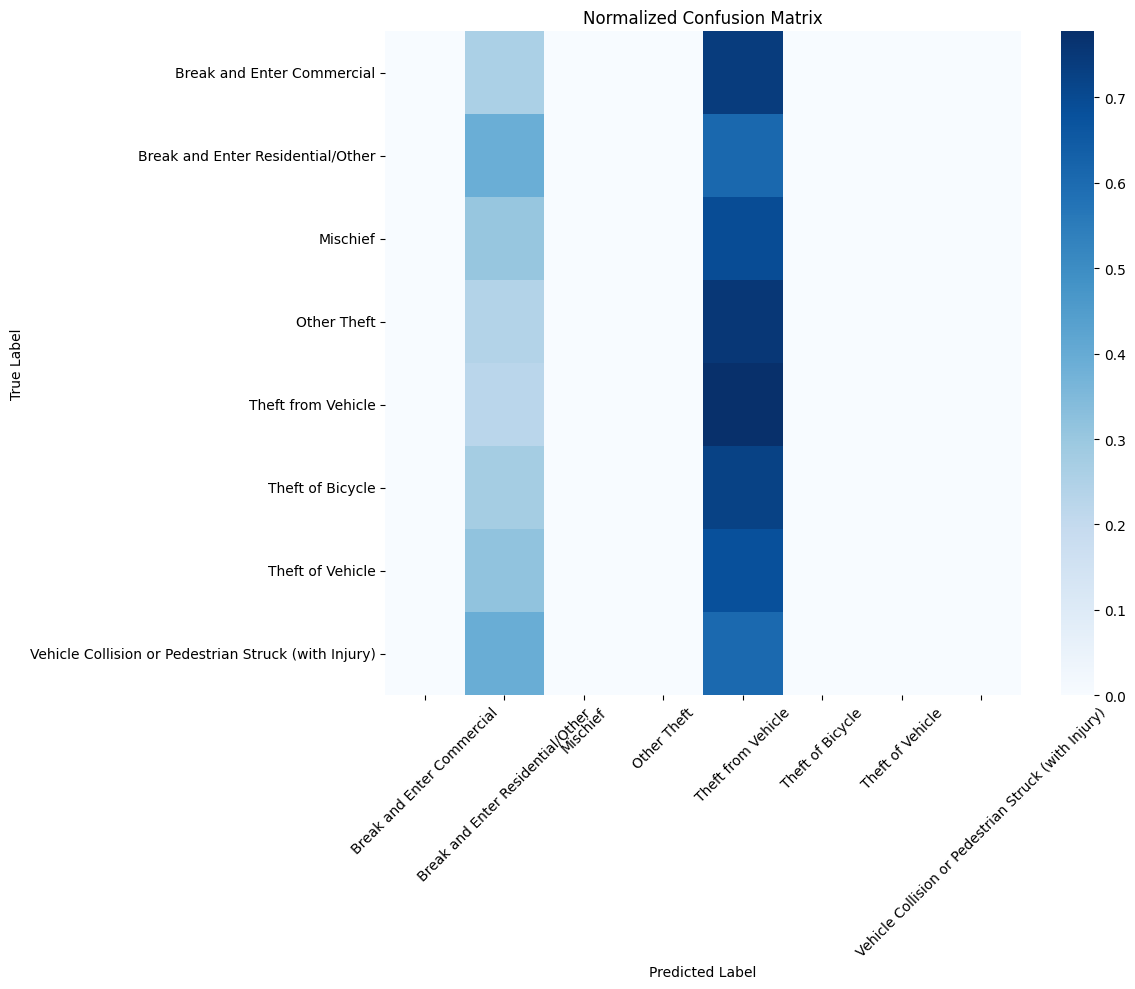

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_loader, label_encoder):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Skorlar
    acc = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted')

    print(f"Accuracy:  {acc:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"Precision: {precision:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=False, cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, fmt='.2f')
    plt.title("Normalized Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    return acc, f1, recall, precision

acc, f1, recall, precision = evaluate_model(trained_model, test_loader, le)

Epoch 1/30 - Loss: 1.7016 - Test Accuracy: 0.3646
Epoch 2/30 - Loss: 1.6797 - Test Accuracy: 0.3617
Epoch 3/30 - Loss: 1.6777 - Test Accuracy: 0.3641
Epoch 4/30 - Loss: 1.6754 - Test Accuracy: 0.3648
Epoch 5/30 - Loss: 1.6746 - Test Accuracy: 0.3641
Epoch 6/30 - Loss: 1.6736 - Test Accuracy: 0.3622
Epoch 7/30 - Loss: 1.6726 - Test Accuracy: 0.3639
Epoch 8/30 - Loss: 1.6720 - Test Accuracy: 0.3640
Epoch 9/30 - Loss: 1.6715 - Test Accuracy: 0.3640
Epoch 10/30 - Loss: 1.6712 - Test Accuracy: 0.3641
Epoch 11/30 - Loss: 1.6711 - Test Accuracy: 0.3636
Epoch 12/30 - Loss: 1.6705 - Test Accuracy: 0.3640
Epoch 13/30 - Loss: 1.6698 - Test Accuracy: 0.3650
Epoch 14/30 - Loss: 1.6699 - Test Accuracy: 0.3662
Epoch 15/30 - Loss: 1.6690 - Test Accuracy: 0.3645
Epoch 16/30 - Loss: 1.6690 - Test Accuracy: 0.3645
Epoch 17/30 - Loss: 1.6689 - Test Accuracy: 0.3646
Epoch 18/30 - Loss: 1.6683 - Test Accuracy: 0.3656
Epoch 19/30 - Loss: 1.6681 - Test Accuracy: 0.3655
Epoch 20/30 - Loss: 1.6677 - Test Accura

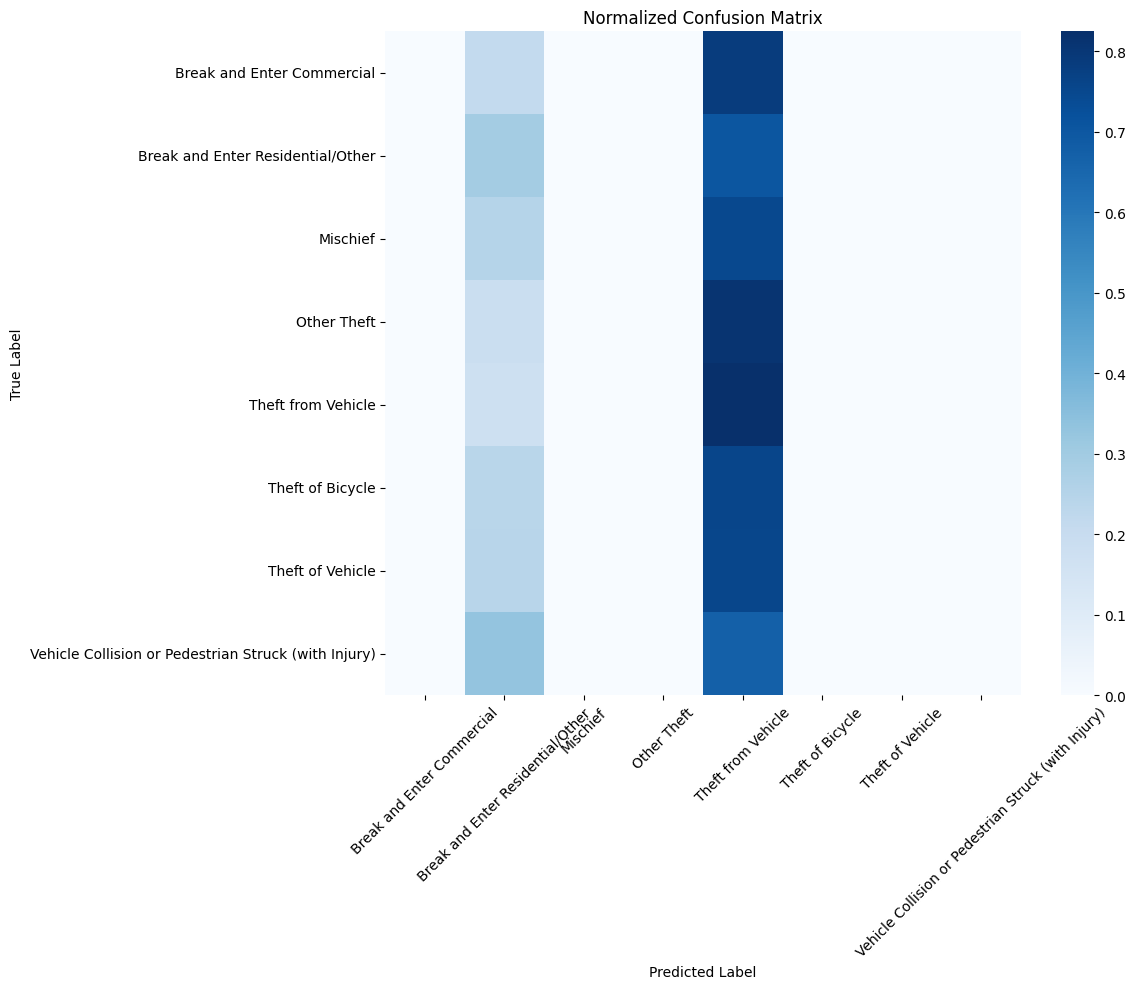

[METRICS] Accuracy: 0.3671, F1: 0.2590, Recall: 0.3671, Precision: 0.2081
Epoch 1/30 - Loss: 1.6969 - Test Accuracy: 0.3434
Epoch 2/30 - Loss: 1.6789 - Test Accuracy: 0.3549
Epoch 3/30 - Loss: 1.6747 - Test Accuracy: 0.3653
Epoch 4/30 - Loss: 1.6729 - Test Accuracy: 0.3655
Epoch 5/30 - Loss: 1.6711 - Test Accuracy: 0.3648
Epoch 6/30 - Loss: 1.6706 - Test Accuracy: 0.3611
Epoch 7/30 - Loss: 1.6698 - Test Accuracy: 0.3640
Epoch 8/30 - Loss: 1.6695 - Test Accuracy: 0.3646
Epoch 9/30 - Loss: 1.6682 - Test Accuracy: 0.3619
Epoch 10/30 - Loss: 1.6684 - Test Accuracy: 0.3630
Epoch 11/30 - Loss: 1.6671 - Test Accuracy: 0.3642
Epoch 12/30 - Loss: 1.6670 - Test Accuracy: 0.3648
Epoch 13/30 - Loss: 1.6671 - Test Accuracy: 0.3652
Epoch 14/30 - Loss: 1.6657 - Test Accuracy: 0.3650
Epoch 15/30 - Loss: 1.6652 - Test Accuracy: 0.3650
Epoch 16/30 - Loss: 1.6646 - Test Accuracy: 0.3684
Epoch 17/30 - Loss: 1.6642 - Test Accuracy: 0.3640
Epoch 18/30 - Loss: 1.6632 - Test Accuracy: 0.3669
Epoch 19/30 - Los

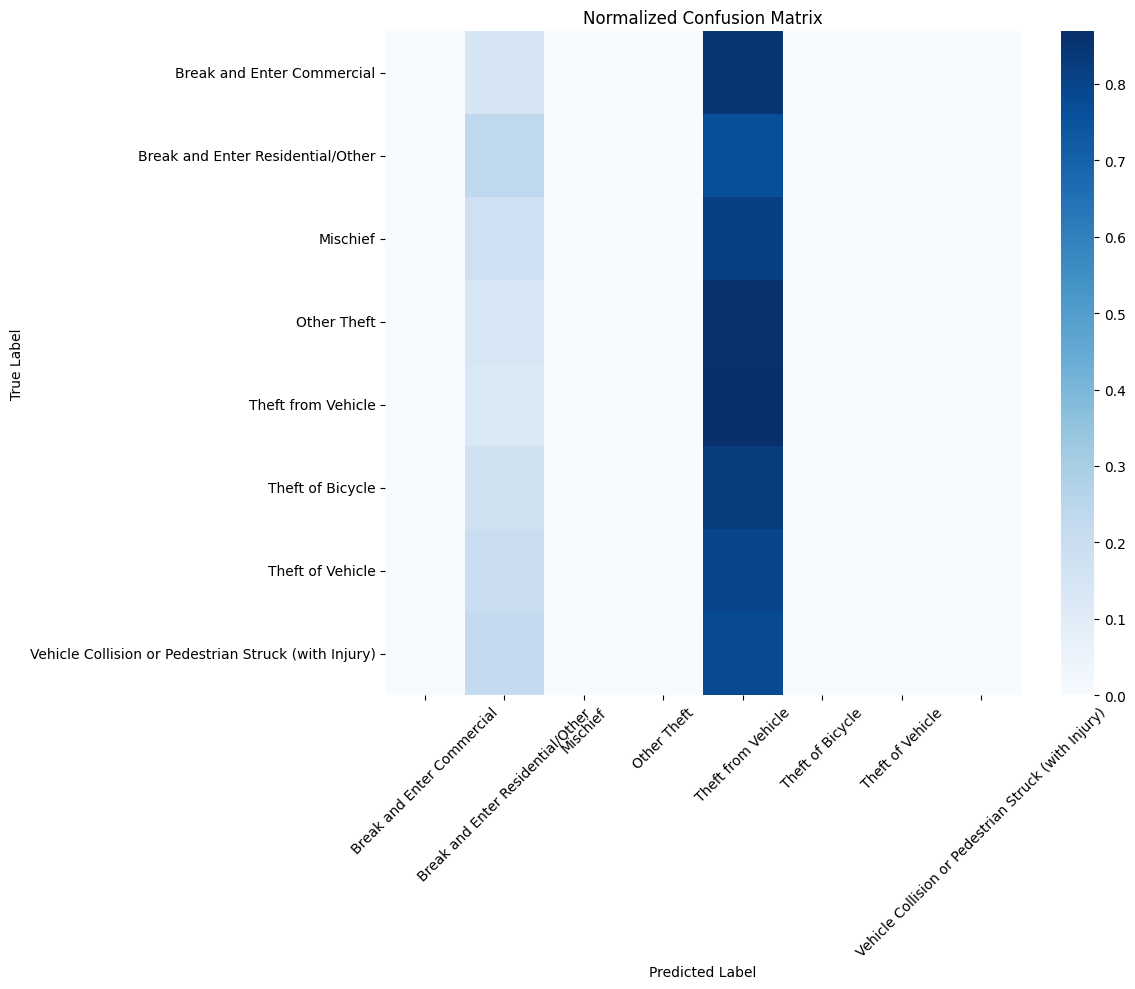

[METRICS] Accuracy: 0.3696, F1: 0.2539, Recall: 0.3696, Precision: 0.2095
Epoch 1/30 - Loss: 1.6939 - Test Accuracy: 0.3640
Epoch 2/30 - Loss: 1.6768 - Test Accuracy: 0.3589
Epoch 3/30 - Loss: 1.6722 - Test Accuracy: 0.3583
Epoch 4/30 - Loss: 1.6695 - Test Accuracy: 0.3652
Epoch 5/30 - Loss: 1.6675 - Test Accuracy: 0.3637
Epoch 6/30 - Loss: 1.6667 - Test Accuracy: 0.3638
Epoch 7/30 - Loss: 1.6658 - Test Accuracy: 0.3639
Epoch 8/30 - Loss: 1.6650 - Test Accuracy: 0.3634
Epoch 9/30 - Loss: 1.6645 - Test Accuracy: 0.3625
Epoch 10/30 - Loss: 1.6640 - Test Accuracy: 0.3647
Epoch 11/30 - Loss: 1.6636 - Test Accuracy: 0.3630
Epoch 12/30 - Loss: 1.6625 - Test Accuracy: 0.3643
Epoch 13/30 - Loss: 1.6617 - Test Accuracy: 0.3681
Epoch 14/30 - Loss: 1.6607 - Test Accuracy: 0.3644
Epoch 15/30 - Loss: 1.6594 - Test Accuracy: 0.3667
Epoch 16/30 - Loss: 1.6586 - Test Accuracy: 0.3674
Epoch 17/30 - Loss: 1.6574 - Test Accuracy: 0.3688
Epoch 18/30 - Loss: 1.6567 - Test Accuracy: 0.3676
Epoch 19/30 - Los

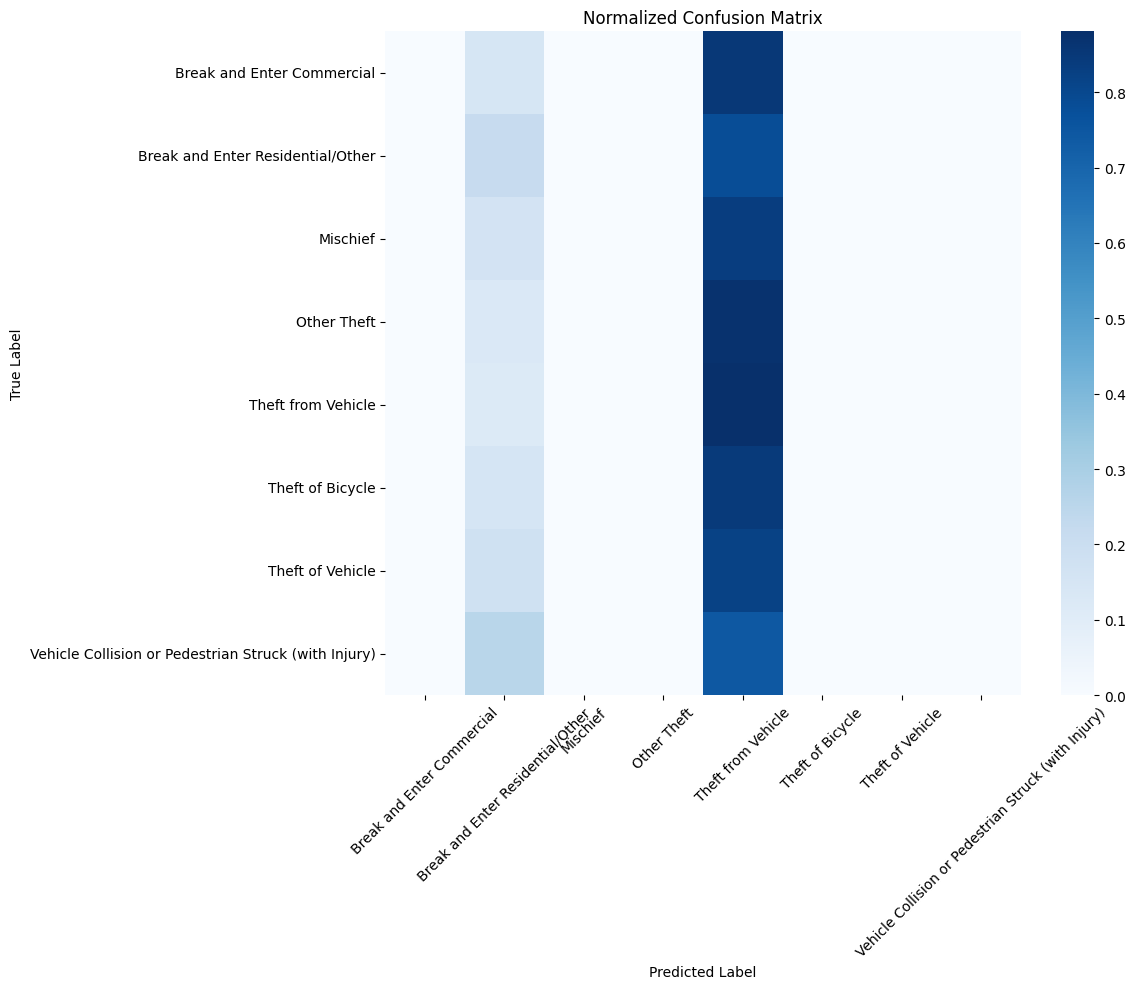

[METRICS] Accuracy: 0.3698, F1: 0.2518, Recall: 0.3698, Precision: 0.2451


In [70]:
def run_experiment(daily_df, window_size=5, hidden_dim=128, batch_size=64, num_epochs=30, lr=0.001, dropout=0.3):

    # 1. Nadir sınıf filtreleme
    value_counts = daily_df['Crime_Mode'].value_counts()
    valid_classes = value_counts[value_counts >= 100].index
    daily_df = daily_df[daily_df['Crime_Mode'].isin(valid_classes)].reset_index(drop=True)
    

    # 2. Sequence oluştur
    X, y, feature_cols = create_sequences_rnn(daily_df, window_size=window_size)

    # 3. Preprocess (normalize + encode)
    X_scaled, y_encoded, scaler, label_encoder = preprocess_sequences_rnn(X, y)

    # 4. Split
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    # 5. Dataset ve Dataloader
    train_dataset = CrimeDataset(X_train, y_train)
    test_dataset = CrimeDataset(X_test, y_test)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # 6. Model
    input_dim = X.shape[2]
    output_dim = len(np.unique(y_encoded))
    model = LSTMClassifier(input_dim, hidden_dim, output_dim, num_layers=1, dropout=dropout)

    # 7. Train
    model = train_model(model, train_loader, test_loader, num_epochs=num_epochs, learning_rate=lr)

    # 8. Save artifacts
    window_tag = f"win{window_size}"

    joblib.dump(scaler, f"scaler_{window_tag}_vanc.pkl")
    joblib.dump(label_encoder, f"label_encoder_{window_tag}_vanc.pkl")
    torch.save(model.state_dict(), f"model_{window_tag}_vanc.pt")

    print(f"[INFO] Model ve encoder/scaler dosyaları kaydedildi: {window_tag}")

    # 9. Evaluate
    acc, f1, recall, precision = evaluate_model(model, test_loader, label_encoder)
    print(f"[METRICS] Accuracy: {acc:.4f}, F1: {f1:.4f}, Recall: {recall:.4f}, Precision: {precision:.4f}")

for win_size in [3, 5, 7]:
    run_experiment(daily_df, window_size=win_size)    